<a href="https://colab.research.google.com/github/sinood/cs194-26_proj4_p3/blob/master/cs192_26_proj4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import random
import skimage as sk
import skimage.transform as sktr
import skimage.io as skio
import time
import matplotlib.pyplot as plt
from skimage.transform import resize

Load dataset

In [ ]:
import os 

if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'

Loading the bounding boxes 

In [134]:
import xml.etree.ElementTree as ET 
import numpy as np


tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32') 

Dataloader

In [136]:
from torch.utils.data import Dataset, DataLoader

def crop_img(im, bbox):
  im = im[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
  return im

def resize_img(im, resize_dim):
  im = resize(im, (resize_dim, resize_dim))
  return im

def crop_resize_keypts(keypoints, bbox, resize_dim, imshape):
  xs = keypoints[:,0] - bbox[0]
  ys = keypoints[:,1] - bbox[1]
  scalar = resize_dim*1.0 / imshape[0]
  xs = xs*scalar
  ys = ys*scalar
  return xs, ys

class LandmarkDataset(Dataset):
  def __init__(self, start_ind, end_ind=len(img_filenames), im_dim=244, ims=None, lndmrks=None):
    self.landmarks = []
    self.imgs = []
    self.start_ind = start_ind
    self.im_dim = im_dim
    if ims is not None and lndmrks is not None:
      # Already have preprocessed landmarks or images to use
      self.imgs = ims
      self.landmarks = lndmrks
    else:
      # Load dataset into memory first to avoid cropping/resizing during training
      for i in range(start_ind, end_ind):
        lndmrk = np.copy(landmarks[i])
        im = sk.color.rgb2gray(skio.imread(img_filenames[i]))
        bbox = bboxes[i].astype(int)
        # Crop to bounding box
        im = crop_img(im, bbox)
        # Resize image and landmarks
        lndmrk[:,0], lndmrk[:,1] = crop_resize_keypts(lndmrk, bbox, self.im_dim, im.shape)
        im = resize_img(im, resize_dim)
        # Save image, landmarks
        self.landmarks.append(lndmrk)
        self.imgs.append(im)

  def __len__(self):
    return len(self.landmarks)

  def __getitem__(self, ind):
    # landmarks = self.landmarks[ind]
    # im_ind = ind + self.start_ind
    # im = sk.color.rgb2gray(skio.imread(img_filenames[im_ind]))
    # bbox = bboxes[im_ind].astype(int)
    # # Crop to bounding box
    # im = crop_img(im, bbox)
    # # Resize image and landmarks
    # to_plot_x, to_plot_y = crop_resize_keypts(landmarks[1599], bbox, resize_dim, im.shape)
    # im = resize_img(im, resize_dim)
    # # Resize
    lndmrk = self.landmarks[ind]
    im = self.imgs[ind]
    sample = {'image': im, 'landmarks': lndmrk}
    return sample


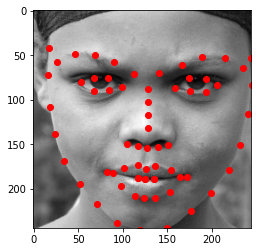

In [143]:
dataset = LandmarkDataset(0, 10)
sample = dataset[7]
im = sample['image']
keypts = sample['landmarks']
plt.scatter(keypts[:, 0], keypts[:, 1],c='red')
plt.imshow(im, cmap='gray')

(6666, 68, 2) (6666, 4) 6666
[570.  52. 180. 180.]
100.31111 [ 55. 141.]


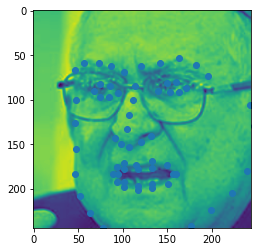

In [141]:


print(landmarks.shape, bboxes.shape, len(img_filenames))
print(bboxes[1599])
im = sk.color.rgb2gray(skio.imread(img_filenames[1599]))
bbox = bboxes[1599].astype(int)
resize_dim = 244

im = crop_img(im, bbox)
to_plot_x, to_plot_y = crop_resize_keypts(landmarks[1599], bbox, resize_dim, im.shape)
print(to_plot_y[0], landmarks[0][0])
im = resize_img(im, resize_dim)

# im = im[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
# to_plot_x = landmarks[1599][:,0] - bbox[0]
# to_plot_y = landmarks[1599][:,1] - bbox[1]
# scalar = resize_dim*1.0 / im.shape[0]
# print(scalar)
# to_plot_x = to_plot_x*scalar
# to_plot_y = to_plot_y*scalar
# im = resize(im, (resize_dim, resize_dim))
plt.scatter(to_plot_x, to_plot_y)
plt.imshow(im)